## Import Modules

In [1]:
import os
import pickle #storing numpy feature
import numpy as np

from tqdm.notebook import tqdm
#for ui to get how much data is processed
import tensorflow as tf
# from tensorflow.keras.application.vgg16 import VGG16, preprocess_input #to preprocess images

from tensorflow.keras.preprocessing.image import load_img, img_to_array #type:ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type:ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #to even out the image #type:ignore
from tensorflow.keras.models import Model #type:ignore
from tensorflow.keras.utils import to_categorical, plot_model #to visualize our model architecture #type:ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, LSTM, Embedding, Dropout, add #type:ignore
from tensorflow.keras.optimizers import Adam #type:ignore
from nltk.translate.bleu_score import corpus_bleu

from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# BASE_DIR = 'kaggle/input/flickr8k'
# WORKING_DIR = 'kaggle/working'
import os
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
WORKING_DIR = os.getcwd()

## EXTRACT IMAGE FEATURES

In [3]:
#CNN MODEL

#restructuring the model
# Define input shape, adjust as per your dataset)
input_layer = Input(shape=(224, 224, 3))

# Custom CNN layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

#flatten_dense
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)

# Final feature extractor model
model = Model(inputs=input_layer, outputs=x)

# Compile for training, or skip if only for feature extraction
# model.compile(optimizer=Adam(), loss='categorical_crossentropy')

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                             

In [4]:
model.save(WORKING_DIR + '/feature_extractor.keras')


In [5]:
#extract features from image
features = {}
directory = os.path.join(BASE_DIR, "Images")

for img_name in tqdm(os.listdir(directory)):
    #load the image from file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert image pixels to numpy array
    image = img_to_array(image)


    # #reshape data for model
    # image = image.reshape(1, image.shape[0], image.shape[1], image.shape[3])

    # #preprocess image for cnn model
    # image = preprocess_image(image)
    
    # Normalize pixel values
    image = image / 255.0

     # Add batch dimension
    image = np.expand_dims(image, axis=0)
    
    #extract features
    feature = model.predict(image, verbose = 0) #so that it wont display other things like text status
    #get image ID
    image_id = img_name.split('.')[0]
    #store feature
    features[image_id]= feature




  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
#store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [10]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [11]:
captions_doc = []

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    for line in f:
        line = line.strip()
        if len(line) < 1:
            continue
        captions_doc.append(line)

print("Total captions loaded:", len(captions_doc))
print("First few lines:")
print(captions_doc[:5])


Total captions loaded: 40455
First few lines:
['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']


In [13]:
#create mapping od image to caption
mapping ={}
#process lines
for line in tqdm(captions_doc):
    # Remove leading/trailing whitespace
    line = line.strip()

    #skip empty lines
    if len(line)<2:
        continue
    

    tokens = line.split(',')
    # Some lines may not split correctly
    if len(tokens) < 2:
        continue

    image_id, caption = tokens[0], tokens[1:]

    #remove ext from image id
    image_id = image_id.split('.')[0]

    #convert caption list to string
    caption = " ".join(caption)

    #create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    
    #store the caption
    mapping[image_id].append(caption)



  0%|          | 0/40455 [00:00<?, ?it/s]

In [15]:
import pickle

with open('mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

In [16]:
len(mapping)

8091

## Preprocess text data

In [17]:
#clean function
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            #take one caption at a time
            caption = captions[i]
            #preprocessing steps
            caption = caption.lower()
            # remove digits and special characters
            # caption = caption.replace('[^A-Za-z]', '') 
            caption = re.sub(r'[^a-z\s]', '', caption)

            #for multiple/additional spaces
            # caption = caption.replace('\s+', ' ') 
            caption = re.sub(r'\s+', ' ', caption).strip()

            #add start and end tages to caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'

            captions[i] = caption


In [18]:
#before preprocessing of text
mapping['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [19]:
#preprocess text
clean(mapping)


In [20]:
#after preprocess
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [21]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [22]:
len(all_captions)

40455

In [23]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [24]:
#tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+ 1 #total number of unique words

In [25]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [26]:
#to load it
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
vocab_size = len(tokenizer.word_index) + 1



In [27]:
#get max length of caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

34

## Train Test Split

In [29]:
image_ids = list(mapping.keys())
split = int(len(image_ids)* 0.90) #90% for training data
train = image_ids[:split]
test = image_ids[split:]

In [30]:
#data generator in batch size 50:31, 53:23

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size): #loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping [key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                # split into input and output pairs
                    in_seq, out_seq= seq[:i], seq[i]
                    # pad input sequence
                    in_seq= pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq= to_categorical([out_seq], num_classes=vocab_size)[0]
                    #store the sequences 
                    X1.append(features[key][0]) 
                    X2.append(in_seq) 
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

In [31]:
print(features[key].shape)


(1, 4096)


## Model Creation

In [32]:
#image feature layer(encoder model)

inputs1 = Input(shape= (4096,)) #consume 4096

#list of features
fe1 = Dropout(0.4)(inputs1) #40% of the elements in inputs1 will be randomly set to 0 during training

fe2= Dense(256, activation='relu')(fe1) #Adds a fully connected layer with 256 neurons. ReLU(x)=max(0,x)

#sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)#as we have padding
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2) #single 256-dim vector summarizing the entire sequence

# decoder model
decoder1= add([fe2,se3])
decoder2 = Dense(256, activation = 'relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


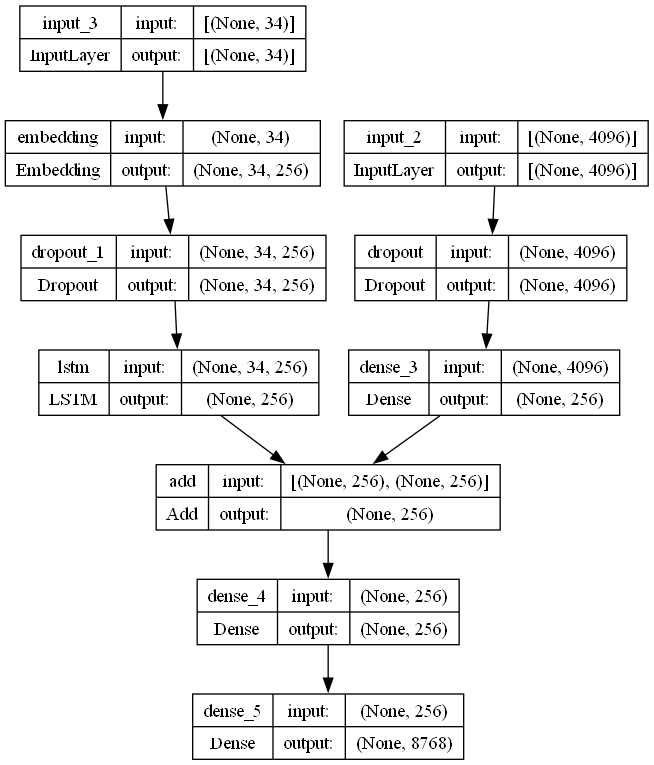

In [33]:
#build the model
model = Model(inputs=[inputs1, inputs2], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',
metrics=['accuracy'])


#plot the model
plot_model(model, show_shapes=True)

In [34]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)
with open('mapping.pkl', 'rb') as f:
        mapping = pickle.load(f)

In [35]:
#train the model
batch_size = 64
steps = len(train) // batch_size

model.fit(
    data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
    epochs=40,
    steps_per_epoch=steps,
    verbose=1
)





Epoch 1/40
113/113 [==============================] - 202s 2s/step - loss: 6.6221 - accuracy: 0.0582
Epoch 2/40
113/113 [==============================] - 193s 2s/step - loss: 5.6250 - accuracy: 0.1012
Epoch 3/40
113/113 [==============================] - 188s 2s/step - loss: 5.0817 - accuracy: 0.1525
Epoch 4/40
113/113 [==============================] - 186s 2s/step - loss: 4.7410 - accuracy: 0.1824
Epoch 5/40
113/113 [==============================] - 181s 2s/step - loss: 4.5077 - accuracy: 0.2029
Epoch 6/40
113/113 [==============================] - 183s 2s/step - loss: 4.3356 - accuracy: 0.2177
Epoch 7/40
113/113 [==============================] - 186s 2s/step - loss: 4.1943 - accuracy: 0.2299
Epoch 8/40
113/113 [==============================] - 181s 2s/step - loss: 4.0689 - accuracy: 0.2397
Epoch 9/40
113/113 [==============================] - 180s 2s/step - loss: 3.9624 - accuracy: 0.2477
Epoch 10/40
113/113 [==============================] - 179s 2s/step - loss: 3.8715 - accura

In [36]:
model.save('model.keras')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [42]:
max_length = 34
vocab_size = 12152

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model('model.keras')
# with open('tokenizer.pkl', 'rb') as f:
#     tokenizer = pickle.load(f)

# with open('features.pkl', 'rb') as f:
#     features = pickle.load(f)

In [ ]:
# batch_size = 64
# steps = len(train) // batch_size
# model.fit(
#     data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),  # 
#     epochs=51,           # total epochs = 30 + 5 = 35
#     initial_epoch=40,    # start from epoch 30
#     steps_per_epoch=steps,
#     verbose=1
# )

In [ ]:
# model.save(WORKING_DIR + '/model.keras')
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


#Generate Captions for image

In [43]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None


In [44]:
def predict_caption(model,image, tokenizer, max_length):
    #add start tag for generation process
    in_text = 'startseq'
    #iterate iver max length of sequence
    for i in range(max_length):
        #encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        #pad the sequence
        sequence= pad_sequences([sequence], max_length)
        #predict next word
        yhat = model.predict([image, sequence], verbose = 0)
        #get index with high prob
        yhat = np.argmax(yhat)

        #convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        #stop if word not found
        if word is None:
            break
        #append word as input for generating next word
        in_text += " " + word
        #stop if we reach end tag
        if word == 'endseq':
            break
        
    return in_text


In [45]:
  
from nltk.translate.bleu_score import corpus_bleu
#validate with test data 
actual, predicted = list(), list()
for key in tqdm(test):
    #get actual caption
    captions = mapping[key]
    #prodict the caption for imago
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split into words
    actual_captions = [caption.split() for caption in captions] 
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions) 
    predicted.append(y_pred)


# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual,predicted, weights=(1.0, 0, 0, 0))) 
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights= (0.5, 0.5, 0, 0)))



  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.151711
BLEU-2: 0.064747


In [46]:
with open('bleu_scores.txt', 'w') as f:
    f.write(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)):.4f}\n")
    f.write(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)):.4f}\n")


#Visualize the Results

In [47]:
from PIL import Image
import matplotlib.pyplot as plt


def generate_caption(image_name):
    #load the image
    # image_name = "667626_18933d713e.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('-----------------Actual--------------')
    for caption in captions:
        print(caption)
    #predict caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('---------------Predicted-------------')
    print(y_pred)
    plt.imshow(image)


-----------------Actual--------------
A brown doberman is outside with a stick in its mouth .
A brown dog shows his teeth .
a dog bites a stick .
A dog is biting a twig .
A dog with sharp teeth is chewing on a stick outside .
---------------Predicted-------------
startseq snowboarder is jumping over snow covered slope with snow in the background on it is in the background of snow is shielding off from ice rink by people in winter clothing and are all


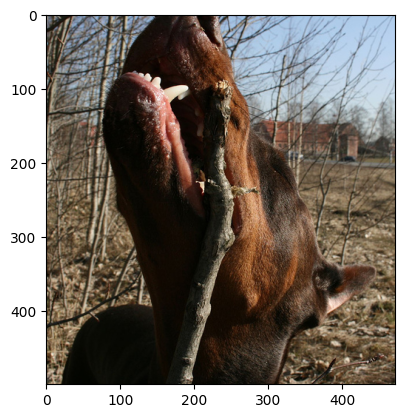

In [48]:
generate_caption("436393371_822ee70952.jpg")

-----------------Actual--------------
A man prepares to enter the red building .
a man walking around the corner of a red building .
A man walks past a red building with a fake rocket attached to it .
A man walks under a building with a large rocket shaped sculpture .
A person walking by a red building with a jet on top of it .
---------------Predicted-------------
startseq jumper is jumping over some rocks on the beach by the ocean with the ocean in the background of the sun is in the foreground is visible up the rainbow are church by the


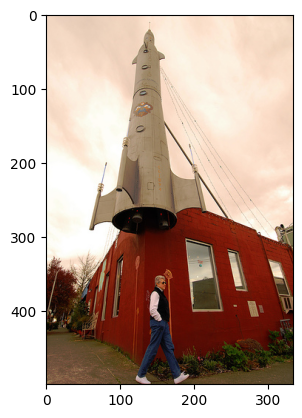

In [49]:
generate_caption("436015762_8d0bae90c3.jpg")

### From diff video

In [50]:
def generate_caption_from_new_image(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    # Clean up the generated caption:
    cleaned_caption = y_pred.replace('startseq', '').replace('endseq', '').strip()
    
    print('---------------Predicted-------------')
    print(cleaned_caption)
    plt.imshow(image)


---------------Predicted-------------
jumper is jumping over some rocks on the beach by the ocean with the ocean in the background of the sun is in the foreground is visible up the rainbow are church by the


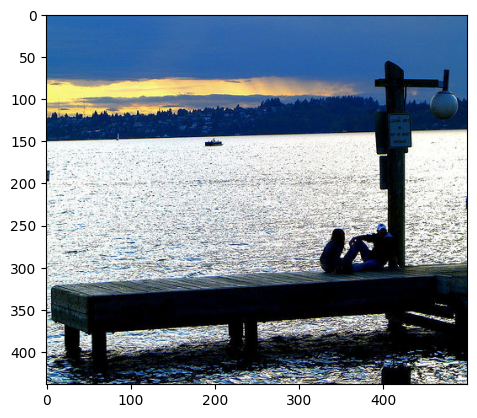

In [52]:
generate_caption_from_new_image("42637986_135a9786a6.jpg")